In [1]:
import os
import json
import shutil
import tempfile
import time
from typing import Tuple
import glob

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.networks.layers import Norm
from monai.transforms import (
    AsDiscrete,
    Activations,
    ScaleIntensityRanged,
    EnsureChannelFirstd,
    Orientationd,
    ScaleIntensityRange,
    RandCropByPosNegLabeld,
    Compose,
    RandRotate90d,
    SpatialCropd,
    KeepLargestConnectedComponent,
    Compose
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR, UNet

from monai.data import decollate_batch, DataLoader, Dataset
from functools import partial

import torch
import torch.optim as optim
import torch.nn as nn

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

from sklearn.model_selection import train_test_split

from model import SegmentationModel

from utils import show_irm

In [2]:
train_transforms_seg = Compose([
    AsDiscrete(rounding="torchrounding")
])

In [3]:
metric = DiceMetric(include_background=False, reduction=MetricReduction.MEAN)

In [4]:
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

file = torch.tensor(nib.load(files[0]).get_fdata()).unsqueeze(0).to(0).float()
model.to(0).float()

seg = nib.load(files_seg[0]).get_fdata()
seg2 = train_transforms_seg(seg)
seg2 = torch.tensor(seg2).to(0)
seg2 = post_label(seg2).unsqueeze(0)

output = model(file)
output_pred = post_pred(output.squeeze(0)).unsqueeze(0)

metric_value = metric(y_pred=output_pred, y=seg2)

NameError: name 'files' is not defined

In [65]:
metric_value

metatensor([[0.]], device='cuda:0')

In [5]:
model = SegmentationModel()

model.load_state_dict(torch.load('model/wholeCuratedWorkingDiceCE/best_metric_model.pth'))

<All keys matched successfully>

In [6]:
files = glob.glob('data/train-512/preprocessed/volume/*')
files_seg = glob.glob('data/train-512/preprocessed/seg/*')

In [33]:
file = torch.tensor(nib.load(files[5]).get_fdata()).unsqueeze(0).to(0).float()
model.to(0).float()

seg = nib.load(files_seg[5]).get_fdata()

In [34]:
mask = model(file)

In [35]:
mask_np = torch.argmax(mask, dim=1).squeeze().cpu().numpy()

In [36]:
mask_np.sum()/mask_np.size

0.004948228597640991

In [41]:
transform = Compose([
    AsDiscrete(rounding="torchrounding")
])
transform(np.array([0.5]))

metatensor([0.])

In [37]:
np.unique(seg)

array([0. , 0.5, 1. ])

In [38]:
video = show_irm(mask_np, file.squeeze().squeeze().cpu().numpy(), seg.squeeze())

In [39]:
video

In [2]:
model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
).to("cuda")
# load
state = torch.load('model/cleanSlidingWindowCorrected/checkpoint copy.pt')

In [3]:
def recursive_removal_module(input_dict):
    newdict = {}
    for key in input_dict.keys():
        newKey = key[7:]
        if isinstance(input_dict[key], dict):
            newdict[newKey] = recursive_removal_module(input_dict[key])
        else:
            newdict[newKey] = input_dict[key]
    return newdict

In [4]:
normal_state = recursive_removal_module(state)

In [5]:
# load
model.load_state_dict(normal_state)

<All keys matched successfully>

In [6]:
def get_loader(batch_size, data_dir, roi):
    """
    Provide data loader for training and validation data.
    """
    images = sorted(glob.glob(os.path.join(data_dir, "volume", "*.nii.gz")))
    segs = sorted(glob.glob(os.path.join(data_dir, "seg", "*.nii.gz")))

    data_dicts = [
        {"image": image_name, "label": seg_name}
        for image_name, seg_name in zip(images, segs)
    ]
    #data_dicts = data_dicts[:40] # Limit data to test the pipeline

    train_files, val_files = train_test_split(data_dicts, train_size=0.8, random_state=0)

    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            #SpatialCropd(keys=["image", "label"], roi_start=(70, 0, 0), roi_end=(512, 512, -1)),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            # Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
            # Probably not needed 
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(roi[0], roi[1], roi[2]),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
            ),
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-1024,
                a_max=3071,
                b_min=0.0,
                b_max=1.0,
                clip=True),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
           # SpatialCropd(keys=["image", "label"], roi_start=(30, 30, 0), roi_end=(512-30, 512-100, 130)),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image"
            ),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            # Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
            # Probably not needed 
            ScaleIntensityRanged(keys=["image"], a_min=-1024, a_max=3071, b_min=0.0, b_max=1.0, clip=True),
        ]
    )

    train_ds = Dataset(data=train_files, transform=train_transform)
    val_ds = Dataset(data=val_files, transform=val_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=6,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=6,
    )

    return train_loader, val_loader

In [7]:
metric = DiceMetric(include_background=False, reduction=MetricReduction.MEAN)
roi = (192, 192, 80)

In [8]:
_, val_data = get_loader(1, "/tsi/data_education/data_challenge/train", roi)

/home/ids/ext-2297/miniconda3/envs/pscc/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


Shape of inputs before post pred:  torch.Size([1, 1, 422, 337, 136])
Shape of labels before post pred:  torch.Size([1, 1, 422, 337, 136])
Metric value:  metatensor([[0.2841]], device='cuda:0')
Metric shape After keeping largest component:  metatensor([[0.]], device='cuda:0')


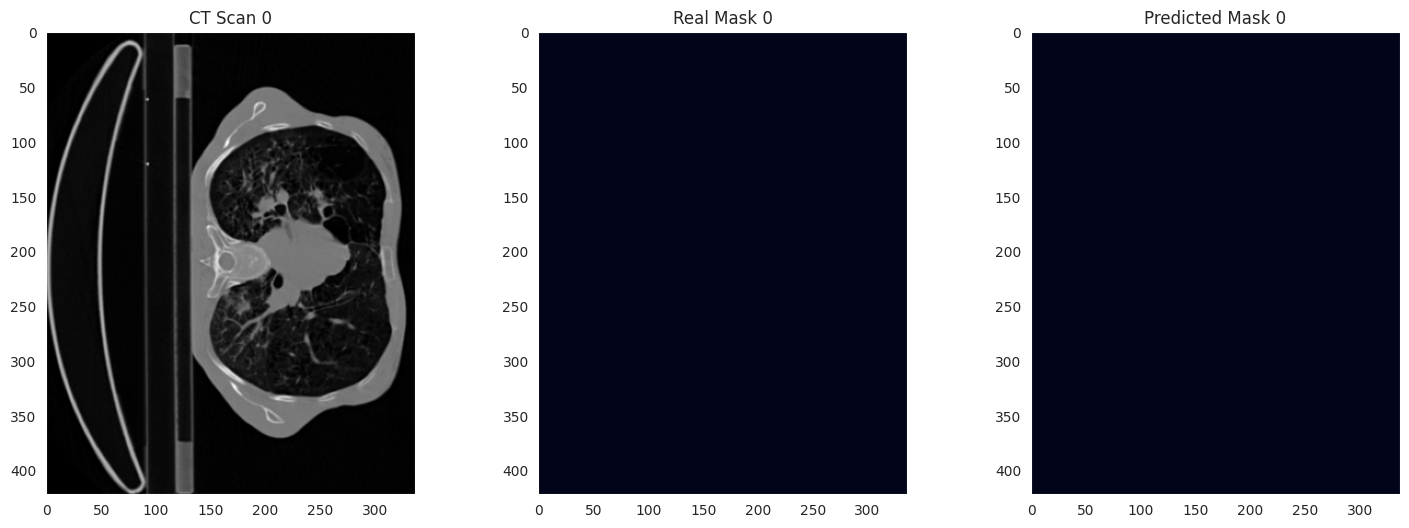

Shape of inputs before post pred:  torch.Size([1, 1, 459, 372, 134])
Shape of labels before post pred:  torch.Size([1, 1, 459, 372, 134])
Metric value:  metatensor([[0.0981]], device='cuda:0')
Metric shape After keeping largest component:  metatensor([[0.]], device='cuda:0')


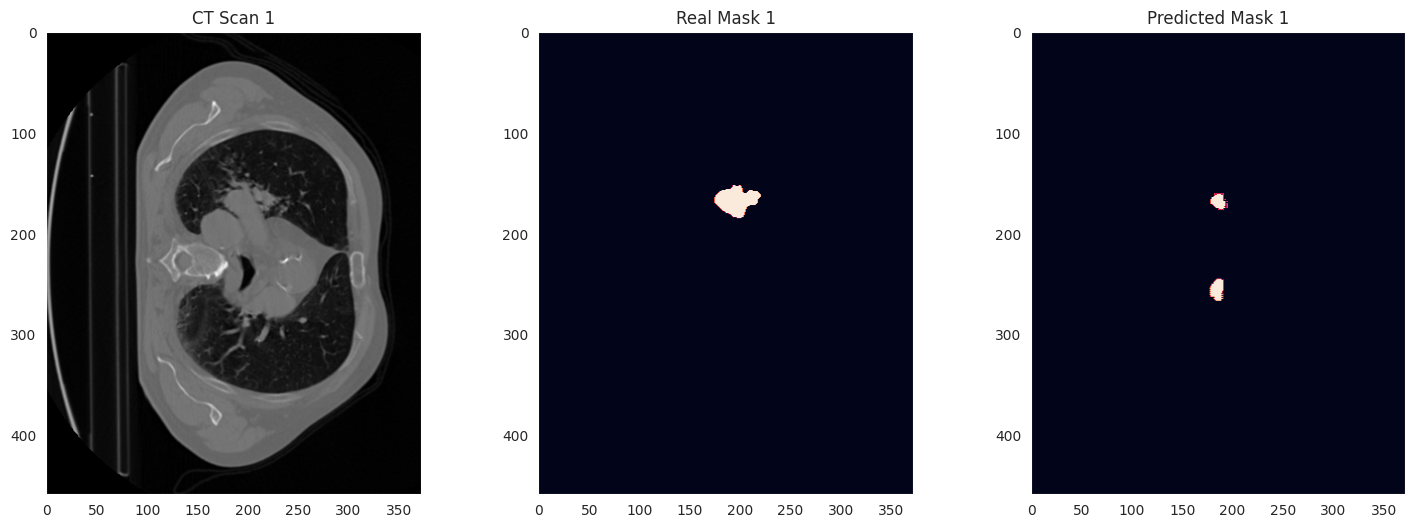

Shape of inputs before post pred:  torch.Size([1, 1, 417, 360, 90])
Shape of labels before post pred:  torch.Size([1, 1, 417, 360, 90])
Metric value:  metatensor([[0.7744]], device='cuda:0')
Metric shape After keeping largest component:  metatensor([[0.7761]], device='cuda:0')


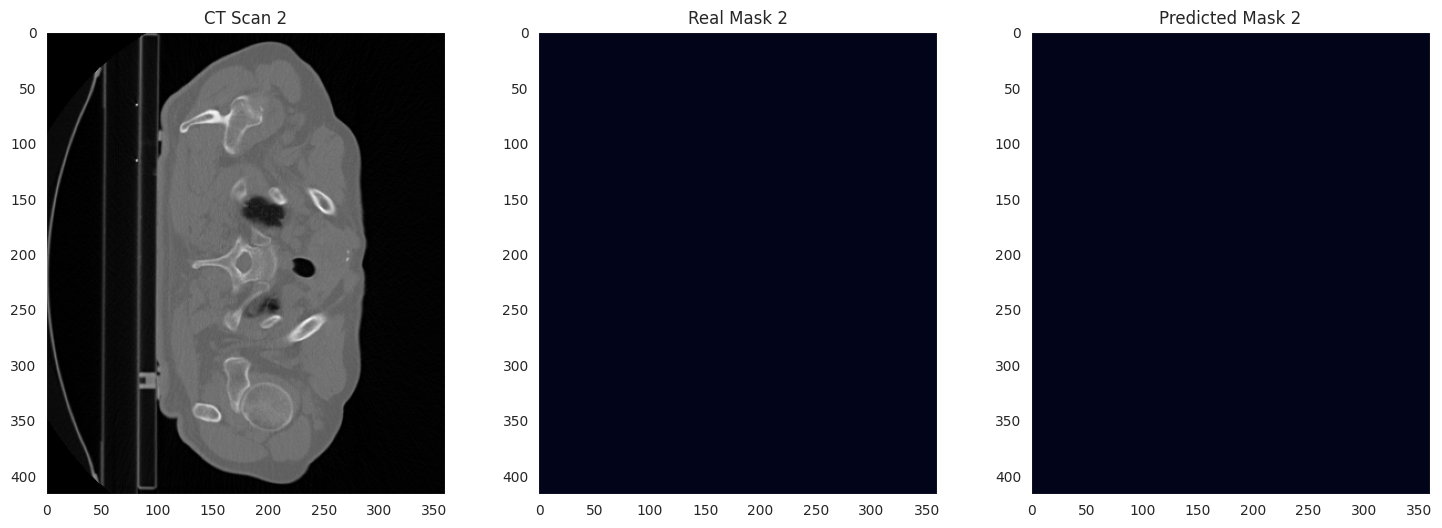

Shape of inputs before post pred:  torch.Size([1, 1, 441, 385, 126])
Shape of labels before post pred:  torch.Size([1, 1, 441, 385, 126])
Metric value:  metatensor([[0.7232]], device='cuda:0')
Metric shape After keeping largest component:  metatensor([[0.7301]], device='cuda:0')


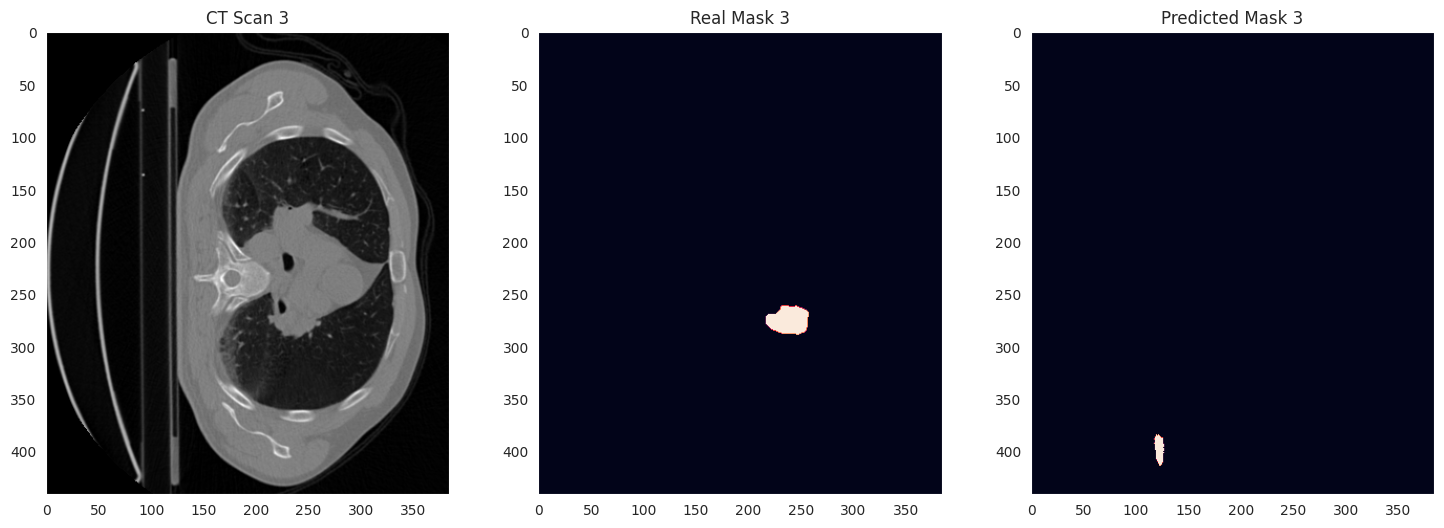

Shape of inputs before post pred:  torch.Size([1, 1, 462, 387, 134])
Shape of labels before post pred:  torch.Size([1, 1, 462, 387, 134])
Metric value:  metatensor([[0.5650]], device='cuda:0')
Metric shape After keeping largest component:  metatensor([[0.6102]], device='cuda:0')


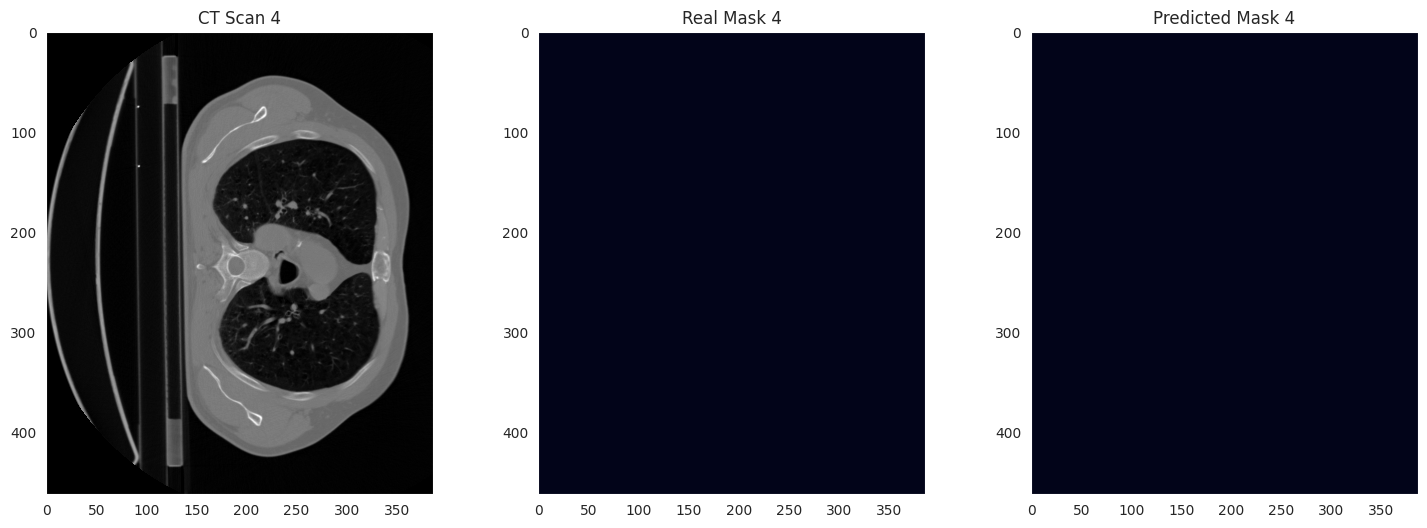

Shape of inputs before post pred:  torch.Size([1, 1, 478, 422, 134])
Shape of labels before post pred:  torch.Size([1, 1, 478, 422, 134])
Metric value:  metatensor([[0.7324]], device='cuda:0')
Metric shape After keeping largest component:  metatensor([[0.8229]], device='cuda:0')


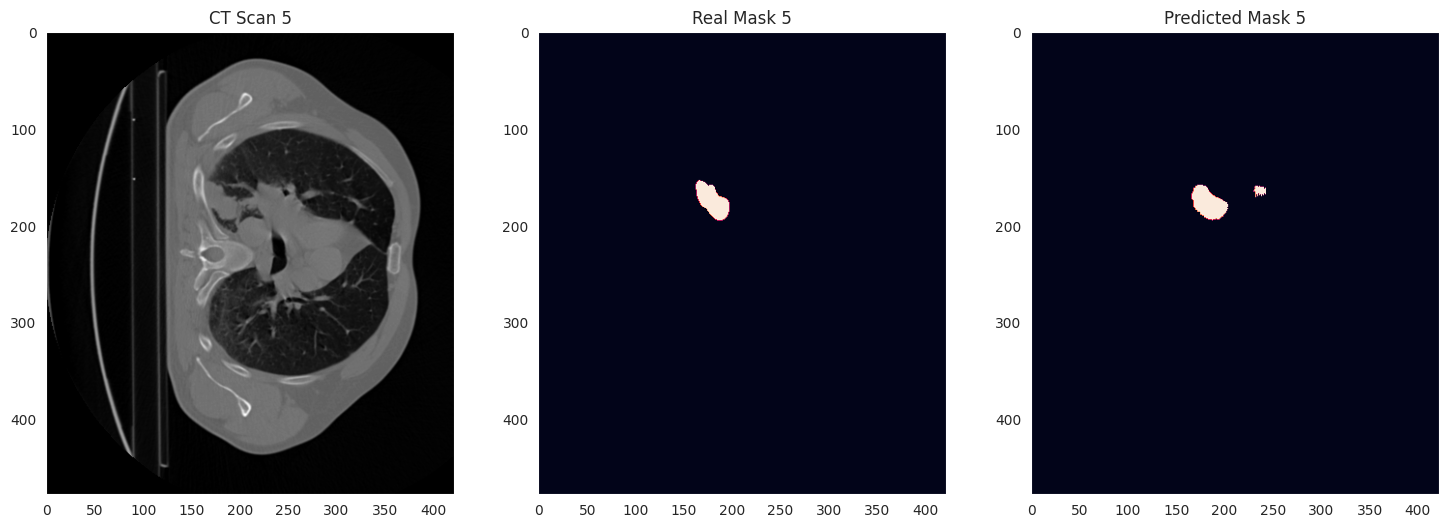

In [51]:
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
mean_metric_history = []
model.eval()
with torch.no_grad():
    for i, batch_data in enumerate(val_data):
        inputs, labels = (
            batch_data["image"].to(0),
            batch_data["label"].to(0),
        )
        print("Shape of inputs before post pred: ", inputs.shape)
        print("Shape of labels before post pred: ", labels.shape)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            inputs, roi, sw_batch_size, model
        )
        val_outputs_post = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(labels)]
        # val_outputs = torch.cat(val_outputs)
        # val_labels = torch.cat(val_labels)
        # print("Shape of inputs after post pred: ", val_outputs.shape)
        # print("Shape of labels after post pred: ", val_labels.shape)
        
        metric_value = metric(y_pred=val_outputs_post, y=val_labels)
        #print("Metric shape: ", metric_value.shape)
        print("Metric value: ", metric_value)

        post_prod_transform = Compose(
            [
                KeepLargestConnectedComponent()
            ]
        )
        #print("Shape of inputs before post prod: ", val_outputs.shape)
        val_outputs_pred = torch.argmax(val_outputs, dim=1)
        #print("Shape of inputs after post prod: ", val_outputs_pred.shape)
        val_outputs_post_prod = post_prod_transform(val_outputs_pred.unsqueeze(0)).squeeze(0)


        val_outputs_post_prod_for_metric = post_label(val_outputs_post_prod)
        val_outputs_post_prod_for_metric = val_outputs_post_prod_for_metric.unsqueeze(0)
        metric_value = metric(y_pred=val_outputs_post_prod_for_metric, y=val_labels)
        print("Metric shape After keeping largest component: ", metric_value)
        

        heigth = 80

        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"CT Scan {i}")
        plt.grid(False)
        plt.imshow(inputs[0, 0, :, :, heigth].cpu().detach(), cmap="gray")
        plt.subplot(1, 3, 2)
        plt.grid(False)
        plt.title(f"Real Mask {i}")
        plt.imshow(labels[0, 0, :, :, heigth].cpu().detach())
        plt.subplot(1, 3, 3)
        plt.title(f"Predicted Mask {i}")
        plt.grid(False)
        # superposition = inputs
        # superposition[labels == 1] = 1
        # plt.imshow(superposition.cpu().detach()[0, 0, :, :, heigth], cmap="gray")
        plt.imshow(torch.argmax(val_outputs, dim=1).cpu().detach()[0, :, :, heigth])
        plt.show()

        if i == 5:
            break
    
    # Aggregate the final mean metric value
    value_metric = metric.aggregate().item()
    mean_metric_history.append(value_metric)
    metric.reset()


# Animation

In [9]:
import nibabel as nib
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
from tqdm import tqdm
sns.set_style("darkgrid")

In [10]:
dataIrm = iter(val_data)

In [11]:
def show_irm(data: np.ndarray, inputs, val_outputs, name=None):
    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Initialize images for each subplot
    im1 = axs[0].imshow(data[:, :, 0], cmap='gray', vmin=0, vmax=1)
    im2 = axs[1].imshow(inputs[:, :, 0], vmin=0, vmax=1)
    im3 = axs[2].imshow(val_outputs[:, :, 0], vmin=0, vmax=1)

    # Function to update the plots for each frame
    def update(frame):
        im1.set_data(data[:, :, frame])
        axs[0].set_title(f'CT scans {frame}')
        axs[0].grid(False)

        im2.set_data(inputs[:, :, frame])
        axs[1].set_title(f"Real Mask (cancer cells) {frame}")
        axs[1].grid(False)

        im3.set_data(val_outputs[:, :, frame])
        axs[2].set_title(f"Prediction Mask {frame}")
        axs[2].grid(False)

    # Create an animation
    num_slices = data.shape[2]
    anim = animation.FuncAnimation(fig, update, frames=num_slices, interval=100, blit=False)
    if name:
        anim.save(os.path.join("video",name), writer='imagemagick', fps=10)
    plt.close()
    return HTML(anim.to_html5_video())

In [12]:
def make_prediction_get_video(dataIrm, roi, name=None):

    post_pred = Compose([AsDiscrete(argmax=True), KeepLargestConnectedComponent()])

    inputs, labels = (
        dataIrm["image"].to(0),
        dataIrm["label"].to(0),
    )
    sw_batch_size = 4
    val_outputs = sliding_window_inference(
        inputs, roi, sw_batch_size, model, overlap=0.8, mode="gaussian"
    )

    val_outputs_post = post_pred(val_outputs.cpu().detach().numpy()[0])

    video = show_irm(inputs.detach().cpu().numpy()[0, 0], labels.cpu().detach().numpy()[0][0], val_outputs_post[0], name=name)
    return video

In [13]:
with torch.no_grad():
    for i, ctScan in tqdm(enumerate(dataIrm)):
        make_prediction_get_video(ctScan, roi, name=f"video{i}.gif")
        

0it [00:00, ?it/s]MovieWriter imagemagick unavailable; using Pillow instead.
1it [01:34, 94.22s/it]MovieWriter imagemagick unavailable; using Pillow instead.
2it [03:03, 91.45s/it]MovieWriter imagemagick unavailable; using Pillow instead.
3it [04:08, 79.42s/it]MovieWriter imagemagick unavailable; using Pillow instead.
4it [05:41, 84.75s/it]MovieWriter imagemagick unavailable; using Pillow instead.
5it [07:02, 83.40s/it]MovieWriter imagemagick unavailable; using Pillow instead.
6it [08:38, 87.71s/it]MovieWriter imagemagick unavailable; using Pillow instead.
7it [09:53, 83.33s/it]MovieWriter imagemagick unavailable; using Pillow instead.
8it [11:01, 78.47s/it]MovieWriter imagemagick unavailable; using Pillow instead.
9it [12:33, 82.88s/it]MovieWriter imagemagick unavailable; using Pillow instead.
10it [13:42, 78.52s/it]MovieWriter imagemagick unavailable; using Pillow instead.
11it [15:08, 80.74s/it]MovieWriter imagemagick unavailable; using Pillow instead.


AttributeError: 'HTML' object has no attribute 'save'

In [18]:
def make_prediction(dataIrm, roi):

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])

    inputs, labels = (
        dataIrm["image"].to(0),
        dataIrm["label"].to(0),
    )

    sw_batch_size = 4
    val_outputs = sliding_window_inference(
        inputs, roi, sw_batch_size, model, overlap=0.5
    )
    val_outputs2 = sliding_window_inference(
        inputs, roi, sw_batch_size, model, overlap=0.8
    )
    # val_outputs3 = sliding_window_inference(
    #     inputs, roi, sw_batch_size, model, overlap=0.7, mode="gaussian"
    # )
    # val_outputs4 = sliding_window_inference(
    #     inputs, roi, sw_batch_size, model, overlap=0.9, mode="gaussian"
    # )


    val_outputs_post = [post_pred(i) for i in decollate_batch(val_outputs)]
    val_outputs_post2 = [post_pred(i) for i in decollate_batch(val_outputs2)]
    # val_outputs_post3 = [post_pred(i) for i in decollate_batch(val_outputs3)]
    # val_outputs_post4 = [post_pred(i) for i in decollate_batch(val_outputs4)]
    val_labels = [post_label(i) for i in decollate_batch(labels)]
    
    metric_value = metric(y_pred=val_outputs_post, y=val_labels)
    metric_value2 = metric(y_pred=val_outputs_post2, y=val_labels)
    # metric_value3 = metric(y_pred=val_outputs_post3, y=val_labels)
    # metric_value4 = metric(y_pred=val_outputs_post4, y=val_labels)

    return metric_value.item(), metric_value2.item()#, metric_value3.item(), metric_value4.item()

In [19]:
# release memory cuda
# torch.cuda.empty_cache()

In [30]:
dataIrm = list(val_data)

In [1]:
from tqdm import tqdm

metric = DiceMetric(include_background=False, reduction=MetricReduction.MEAN)
roi = (320, 320, 96)

with torch.no_grad():
    metric_history = []
    metric_history2 = []
    metric_history3 = []
    metric_history4 = []
    for i in tqdm(range(0, 10)):
        metric1, metric2= make_prediction(dataIrm[i], roi)
        metric_history.append(metric1)
        metric_history2.append(metric2)
        # metric_history3.append(metric3)
        # metric_history4.append(metric4)

print("Mean metric: ", np.mean(metric_history))
print("Mean metric2: ", np.mean(metric_history2))
# print("Mean metric3: ", np.mean(metric_history3))
# print("Mean metric4: ", np.mean(metric_history4))
    

NameError: name 'DiceMetric' is not defined

In [ ]:
video_liste = []
with torch.no_grad():
    for i, batch_data in enumerate(val_data):
        video_liste.append(make_prediction_get_video(batch_data, roi))

Metric value:  metatensor([[0.]], device='cuda:0')
Metric value post prod:  metatensor([[0.]])
#######
Metric value:  metatensor([[0.6439]], device='cuda:0')
Metric value post prod:  metatensor([[0.7715]])
#######
Metric value:  metatensor([[0.6764]], device='cuda:0')
Metric value post prod:  metatensor([[0.6765]])
#######
Metric value:  metatensor([[0.7738]], device='cuda:0')
Metric value post prod:  metatensor([[0.7738]])
#######
Metric value:  metatensor([[0.2737]], device='cuda:0')
Metric value post prod:  metatensor([[0.2721]])
#######
Metric value:  metatensor([[0.6143]], device='cuda:0')
Metric value post prod:  metatensor([[0.8154]])
#######
Metric value:  metatensor([[0.5044]], device='cuda:0')
Metric value post prod:  metatensor([[0.5373]])
#######
Metric value:  metatensor([[0.1929]], device='cuda:0')
Metric value post prod:  metatensor([[0.1820]])
#######
Metric value:  metatensor([[0.]], device='cuda:0')
Metric value post prod:  metatensor([[0.]])
#######
Metric value:  me

In [ ]:
inputs, labels = (
    data["image"].to("cpu"),
    data["label"].to("cpu"),
)

In [ ]:
ex = labels.argwhere()[0]